In [1]:
import pandas as pd
import numpy as np
from utils import sim_filter
import os
import seaborn as sns
from matplotlib import pyplot as plt
from dataclasses import dataclass
from aesthetics import remove_some_spines, remove_sticks, invisible
from utils import smi2array
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from sklearn.manifold import TSNE
from utils import smi2array

In [2]:
@dataclass
class data:
    scores: float
    generation: int
    screened: float
    Method: str
    Data: str

names = {
         "spacega": "REAL",
         "explore": "eXplore"
        }
palette = ["#1f90fe", "#9163cd"]

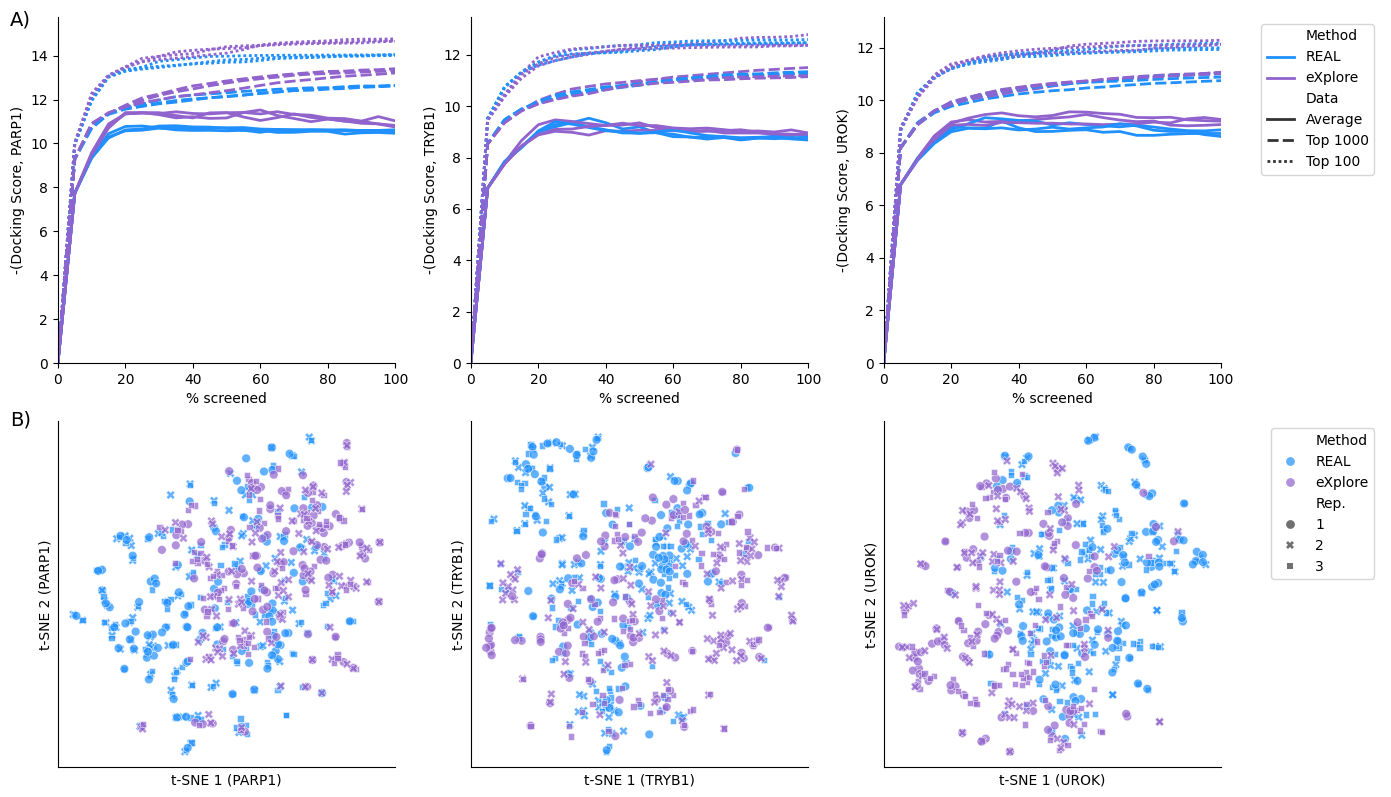

In [3]:
fig, axes = plt.subplots(2, 4, figsize=(14, 8), width_ratios=[4, 4, 4, 1])

# Add (0,0) to plot
dummy = pd.DataFrame({"scores": np.zeros(6), 
                      "generation": np.zeros(6), 
                      "screened": np.zeros(6),
                      "Method": list(names.values())*3,
                      "Data": ["Average"]*2 + ["Top 1000"]*2 + ["Top 100"]*2
                     })

# Collect data from trajectories
for i, protein in enumerate(["PARP1", "TRYB1", "UROK"]):
    for rep in range(1,4):
        df = []
        for name in names:
            d = f"../{name}/{protein}/{rep}/"
            gens = [f for f in os.listdir(d) if f.startswith("gen")]
            n_gens = max([int(gen.split(".")[0][4:]) for gen in gens])
            Data = "Average"
            n = 100/n_gens

            # Get average scores
            for g in range(1, n_gens+1): 
                f = f'gen_{g}.parquet'
                scores = pd.read_parquet(os.path.join(d, f)).scores
                score = scores[scores > 0].mean()
                df.append(data(scores=score, generation=g, screened=g*n, Method=names[name], Data=Data))

            # Get top1000 and top100
            populations = pd.read_parquet(os.path.join(d, "all.parquet"))
            for g, subset in populations.groupby("current"):
                subset = subset.sort_values("scores", ascending=False)
                df.append(data(scores=subset.scores.mean(), generation=g, screened=g*n, Method=names[name], Data="Top 1000"))
                df.append(data(scores=subset.head(100).scores.mean(), generation=g, screened=g*n, Method=names[name], Data="Top 100"))
        
        # Add (0,0) to plot
        df = pd.concat([pd.DataFrame(df), dummy]) 
        df = df.sort_values("Method")
        ax = axes[0, i]
        sns.lineplot(df, x="screened", y="scores", hue="Method", style="Data", palette=palette, ax=ax, legend=False, lw=2)
        ax.set_xlim(0,100)
        ax.set_ylim(0, df.scores.max()+1)
        ax = remove_some_spines(ax)
        ax.set_xlabel("% screened")
        ax.set_ylabel(f"-(Docking Score, {protein})")
        

# Add a legend
ax = axes[0, -1]
ax = invisible(ax)
ax.set_xlim(-2,-1)
sns.lineplot(df, x="screened", y="scores", hue="Method", style="Data", palette=palette, ax=ax, legend=True, lw=2)



# Collect data for t-sne plots
top = []
for name in names:
    for protein in ["UROK", "TRYB1", "PARP1"]:
        for rep in range(1,4):
            f = f"../{name}/{protein}/{rep}/final.parquet"
            df = pd.read_parquet(f)[["scores", "smi"]]
            df["Rep."] = str(rep)
            df["Protein"] = protein
            df["Method"] = names[name]
            df["FP"] = [smi2array(smi) for smi in df.smi]
            top.append(df.sort_values("scores", ascending=False).head(100))
top = {protein: subset for protein, subset in pd.concat(top).groupby("Protein")}

# Perform dimensionality reduction and make t-sne plots
for i, protein in enumerate(["PARP1", "TRYB1", "UROK"]):
    ax = axes[1, i]
    ax = remove_some_spines(ax)
    ax.set_xlabel(f"t-SNE 1 ({protein})")
    ax.set_ylabel(f"t-SNE 2 ({protein})")
    ax = remove_sticks(ax)
    df = top[protein]
    X = np.array(list(df.FP))
    df["x"], df["y"] = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5, random_state=0).fit_transform(X).T
    df = df.sort_values(["Rep."])
    sns.scatterplot(df.sort_values("Method"), x="x", y="y", hue="Method", style="Rep.", alpha=0.7, 
                    palette=palette, s=40, ax=ax, legend=False, lw=0.5)


# Add a legend
ax = axes[1, -1]
ax = invisible(ax)
ax.set_ylim(df.y.min()-10,df.y.min()-1)
sns.scatterplot(df.sort_values("Method"), x="x", y="y", hue="Method", style="Rep.", alpha=0.7, 
                palette=palette, s=40, ax=ax, legend=True, lw=0)



fig.tight_layout()
fig.text(0.01, 0.99, 'A)', fontsize=14, verticalalignment='top', horizontalalignment='left')
fig.text(0.01, 0.49, 'B)', fontsize=14, verticalalignment='top', horizontalalignment='left')
plt.savefig("../figures/comb_emolecule.pdf")